# **Project: Advance Lane Finding** 

In this project, your goal is to write a software pipeline to identify the lane boundaries in video from a front-facing camera on a car. The camera calibration images, test road images, and videos are available in this repository. Your job is to take what you've learned in this lesson and write a great lane-finding pipeline!  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images).

There is no starter code provided, but you are welcome to use code from the lesson and quizzes as you like. You may complete the project in a jupyter notebook, but it's not required. Feel free to build it as a standalone project. 

For this project, you need to complete the following steps:

First, compute the camera calibration matrix and distortion coefficients given a set of chessboard images (in the camera_cal folder in the repository).

Next, for a series of test images (in the test_images folder in the repository):

    - Apply the distortion correction to the raw image.
    - Use color transforms, gradients, etc., to create a thresholded binary image.
    - Apply a perspective transform to rectify binary image ("birds-eye view").
    - Detect lane pixels and fit to find lane boundary.
    - Determine curvature of the lane and vehicle position with respect to center.
    - Warp the detected lane boundaries back onto the original image.
    - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Once you have implemented a successful pipeline on the test images, you will run your algorithm on a video. In the case of the video, you must search for the lane lines in the first few frames, and, once you have a high-confidence detection, use that information to track the position and curvature of the lines from frame to frame.

## Camera Calibration with OpenCV

**I ran the code in the cell below to extract object points and image points from the set of chessboard images for camera calibration, and apply distortion correction `undistort()` function to them. **

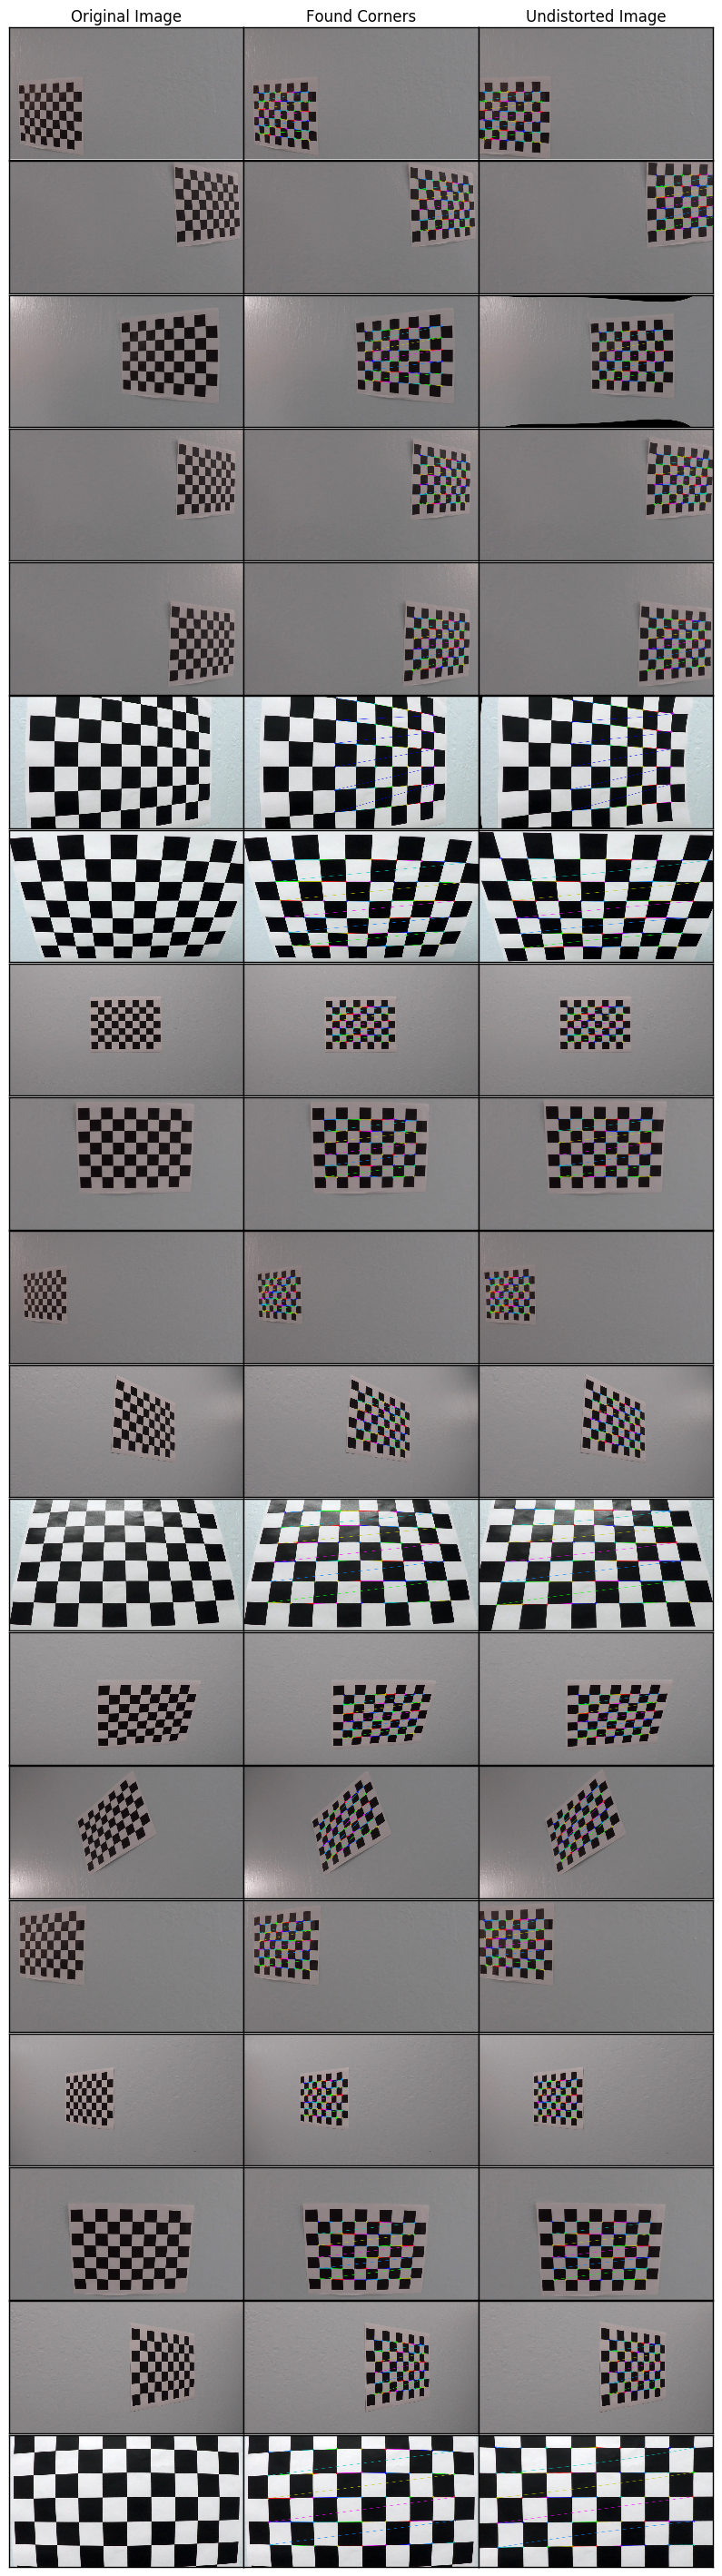

In [85]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import re
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# The images may have different detected checker board dimensions!
# Currently, possible dimension combinations are: (9,6), (8,6), (9,5), (9,4) and (7,6)
objp1 = np.zeros((6*9,3), np.float32)
objp1[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
objp2 = np.zeros((6*8,3), np.float32)
objp2[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)
objp3 = np.zeros((5*9,3), np.float32)
objp3[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)
objp4 = np.zeros((4*9,3), np.float32)
objp4[:,:2] = np.mgrid[0:9, 0:4].T.reshape(-1,2)
objp5 = np.zeros((6*7,3), np.float32)
objp5[:,:2] = np.mgrid[0:7, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Setup plot
fig = plt.figure(figsize=(10, len(images)*1.9))
w_ratios = [1 for n in range(3)]
h_ratios = [1 for n in range(len(images))]
grid = gridspec.GridSpec(len(images), 3, wspace=0.0, hspace=0.0, width_ratios=w_ratios, height_ratios=h_ratios)
i = 0

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img2 = np.copy(img)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners using possible combinations of dimensions.
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    objp = objp1
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
        objp = objp2
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
        objp = objp3
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (9,4), None)
        objp = objp4
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
        objp = objp5
    # print("corners: ", corners.shape, "\n", corners)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img2, (corners.shape[1],corners.shape[0]), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        img3 = cv2.undistort(img2, mtx, dist, None, mtx)

        # next image
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img)
        if i==0:
            ax.set_title('Original Image')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img2)
        if i==1:
            ax.set_title('Found Corners')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img3)
        if i==2:
            ax.set_title('Undistorted Image')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1

    else:
        # next image
        ax = plt.Subplot(fig, grid[i])
        ax.set_title('Corners Not Found!')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 3
plt.show()


## Apply the OpenCV distortion correction to the raw images.

Now let's create a pipeline that uses OpenCV `undistort()` function to apply distortion correction.

**I ran the code in the two cells below to create a pipeline to correct distortion, and then apply it to test images.**

In [86]:
# Current pipeline
# - distortion correction
def process_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

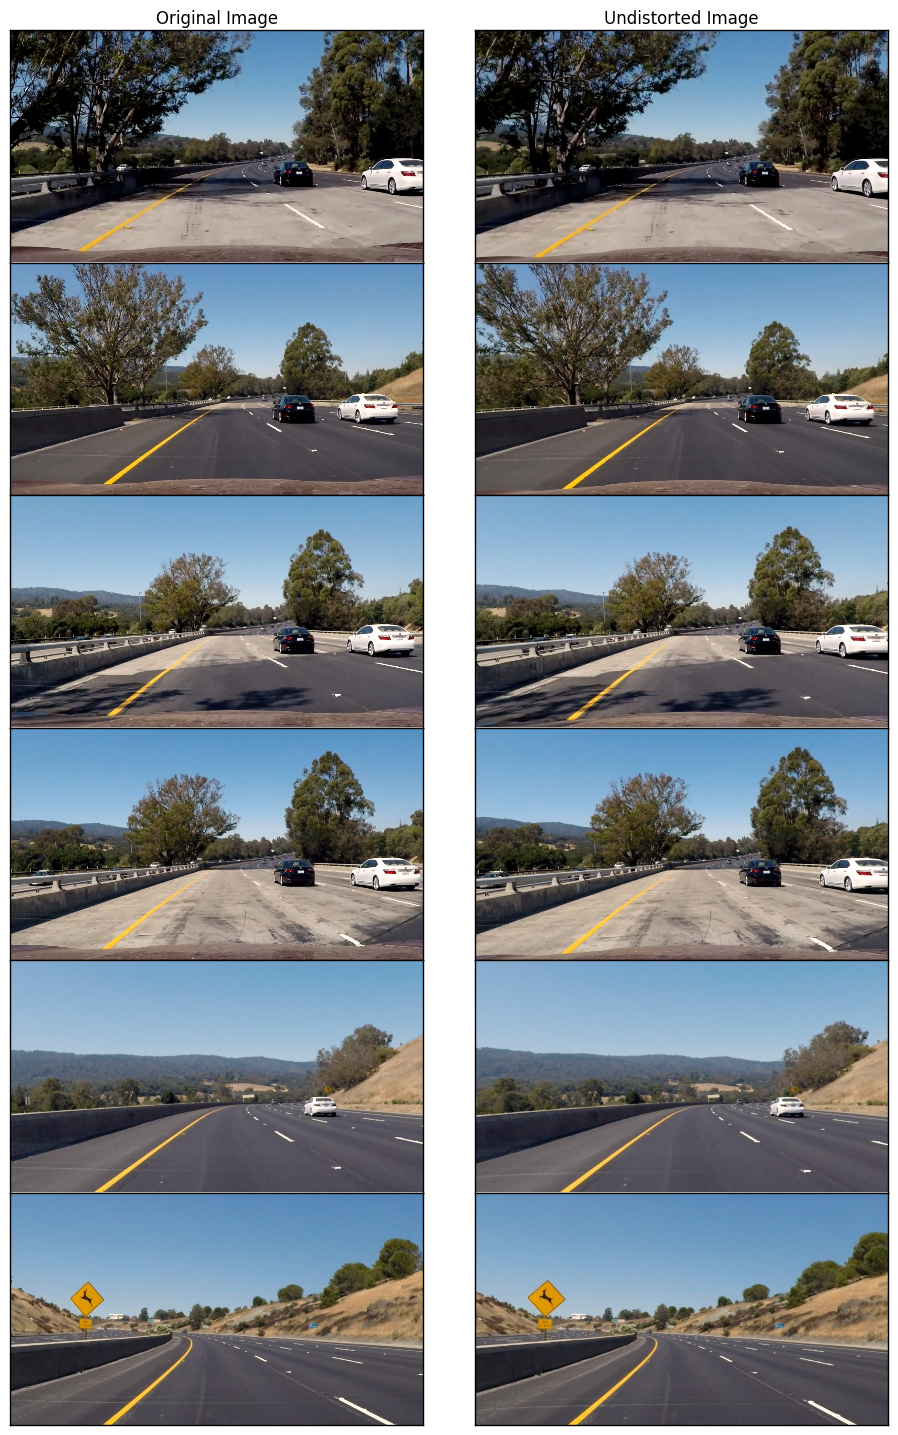

In [87]:
# Make a list of test images
filepath = "test_images/"
pattern = re.compile("^.+processed.jpg$")
images = glob.glob(filepath+'test*.jpg')

# Setup plot
fig = plt.figure(figsize=(12, len(images)*3))
w_ratios = [1 for n in range(2)]
h_ratios = [1 for n in range(len(images))]
grid = gridspec.GridSpec(len(images), 2, wspace=0.0, hspace=0.0, width_ratios=w_ratios, height_ratios=h_ratios)
i = 0

# loop through and display test images and undististort them
for idx, fname in enumerate(images):
    # import the image if it is not a saved output
    if not pattern.match(fname):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_size = (img.shape[1], img.shape[0])
        
        # process image
        img2 = process_image(img)
        
        # next image
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img)
        if i==0:
            ax.set_title('Original Image')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img2)
        if i==1:
            ax.set_title('Undistorted Image')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        
plt.show()


## Detect lane pixels and fit to find lane boundary.

Now let's update the pipeline to include lane and lane boundary detection.

**I ran the code in the two cells below to update the pipeline to detect lane pixels, fit to find lane boundaries, and apply them to test images.**

In [1030]:
## Import math module and create some helper functions

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    if orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    ret, binary_output = cv2.threshold(scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    # Return the result
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 6) Create a binary mask where mag thresholds are met
    ret, mag_binary = cv2.threshold(gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
    # 7) Return this mask as your binary_output image
    return mag_binary

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the direction of the gradient
    # 4) Take the absolute value
    with np.errstate(divide='ignore', invalid='ignore'):
        dirout = np.absolute(np.arctan(sobely/sobelx))
        # 5) Create a binary mask where direction thresholds are met
        dir_binary =  np.zeros_like(dirout).astype(np.float32)
        dir_binary[(dirout > thresh[0]) & (dirout < thresh[1])] = 1
        # 6) Return this mask as your binary_output image
    # update nan to number
    np.nan_to_num(dir_binary)
    # make it fit
    dir_binary[(dir_binary>0)|(dir_binary<0)] = 128
    return dir_binary.astype(np.uint8)

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the sobel functions,
    should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img.astype(np.uint8), α, img.astype(np.uint8), β, λ)

# Define a function that thresholds the S-channel of HLS
def hls_s(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return s_binary

# Define a function that thresholds the S-channel of HLS
def hls_h(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    retval, h_binary = cv2.threshold(h.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return h_binary

# create a region of interest mask
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# draw outline of given area
def draw_area_of_interest(img, areas, color=[128,0,128], thickness=2):
    for points in areas:
        for i in range(len(points)-1):
            cv2.line(img, (points[i][0], points[i][1]), (points[i+1][0],points[i+1][1]), color, thickness)
        cv2.line(img, (points[0][0], points[0][1]), (points[len(points)-1][0],points[len(points)-1][1]), color, thickness)

# draw outline of given area
def draw_area_of_interest_for_projection(img, areas, color=[128,0,128], thickness1=2, thickness2=10):
    for points in areas:
        for i in range(len(points)-1):
            if i==0 or i==1:
                cv2.line(img, (points[i][0], points[i][1]), (points[i+1][0],points[i+1][1]), color, thickness1)
            else:
                cv2.line(img, (points[i][0], points[i][1]), (points[i+1][0],points[i+1][1]), color, thickness2)
        cv2.line(img, (points[0][0], points[0][1]), (points[len(points)-1][0],points[len(points)-1][1]), color, thickness1)

# calculate and draw initial estimated lines
def draw_lines(img, lines, color=[255, 0, 0], thickness=6, debug=False):
    ysize = img.shape[0]
    try:
        # rightline and leftline cumlators
        rl = {'num':0, 'slope':0.0, 'x1':0, 'y1':0, 'x2':0, 'y2':0}
        ll = {'num':0, 'slope':0.0, 'x1':0, 'y1':0, 'x2':0, 'y2':0}
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = ((y2-y1)/(x2-x1))
                if slope > 0.5 and slope < 1.0:   # right
                    rl['num'] += 1
                    rl['slope'] += slope
                    rl['x1'] += x1
                    rl['y1'] += y1
                    rl['x2'] += x2
                    rl['y2'] += y2
                elif slope > -1.0 and slope < -0.5:   # left
                    ll['num'] += 1
                    ll['slope'] += slope
                    ll['x1'] += x1
                    ll['y1'] += y1
                    ll['x2'] += x2
                    ll['y2'] += y2

        if rl['num'] > 0 and ll['num'] > 0:
            # average/extrapolate all of the lines that makes the right line
            rslope = rl['slope']/rl['num']
            rx1 = int(rl['x1']/rl['num'])
            ry1 = int(rl['y1']/rl['num'])
            rx2 = int(rl['x2']/rl['num'])
            ry2 = int(rl['y2']/rl['num'])
            
            # average/extrapolate all of the lines that makes the left line
            lslope = ll['slope']/ll['num']
            lx1 = int(ll['x1']/ll['num'])
            ly1 = int(ll['y1']/ll['num'])
            lx2 = int(ll['x2']/ll['num'])
            ly2 = int(ll['y2']/ll['num'])
            
            # find the right and left line's intercept, which means solve the following two equations
            # rslope = ( yi - ry1 )/( xi - rx1)
            # lslope = ( yi = ly1 )/( xi - lx1)
            # solve for (xi, yi): the intercept of the left and right lines
            # which is:  xi = (ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope)
            # and        yi = ry2 + rslope*(xi-rx2)
            xi = int((ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope))
            yi = int(ry2 + rslope*(xi-rx2))
            
            # calculate backoff from intercept for right line
            if rslope > 0.5 and rslope < 1.0:   # right
                ry1 = yi + thickness*5
                rx1 = int(rx2-(ry2-ry1)/rslope)
                ry2 = ysize-1
                rx2 = int(rx1+(ry2-ry1)/rslope)
                cv2.line(img, (rx1, ry1), (rx2, ry2), [255, 0, 0], thickness)

            # calculate backoff from intercept for left line
            if lslope < -0.5 and lslope > -1.0:   # left
                ly1 = yi + thickness*5
                lx1 = int(lx2-(ly2-ly1)/lslope)
                ly2 = ysize-1
                lx2 = int(lx1+(ly2-ly1)/lslope)
                cv2.line(img, (lx1, ly1), (lx2, ly2), [255, 0, 0], thickness)
                
            if lx1 > 0 and ly1 > 0 and rx1 > 0 and ry1 > 0:
                cv2.line(img, (lx1, ly1), (rx1, ry1), [255, 0, 0], thickness)

        return lslope+rslope, lslope, rslope, (lx1,ly1), (rx1,ry1), (rx2, ry2), (lx2, ly2)
    except:
        return -1000, 0.0, 0.0, (0,0), (0,0), (0,0), (0,0)

# draw parallel lines in a perspective image that will later be projected into a flat surface
def draw_parallel_lines_pre_projection(img, lane_info, color=[128,0,0], thickness=5):
    lx1 = lane_info[3][0]
    rx1 = lane_info[4][0]
    rx2 = lane_info[5][0]
    lx2 = lane_info[6][0]
    ly1 = lane_info[3][1]
    ry1 = lane_info[4][1]
    ry2 = lane_info[5][1]
    ly2 = lane_info[6][1]
    cv2.line(img, (lx1, ly1), (lx2, ly2), color, thickness)
    cv2.line(img, (rx1, ry1), (rx2, ry2), color, thickness)

# generate a set of hough lines and calculates its estimates for lane lines
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, debug=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn using the new single line for left and right lane line method.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    masked_lines = np.zeros(img.shape, dtype=np.uint8)
    lane_info = draw_lines(masked_lines, lines, debug=debug)
    
    return masked_lines, lane_info

# function to project the undistorted camera image to a plane looking down.
def unwarp_lane(img, src, dst, mtx):
    # Pass in your image, 4 source points src = np.float32([[,],[,],[,],[,]])
    # and 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # Note: you could pick any four of the detected corners 
    # as long as those four corners define a rectangle
    # One especially smart way to do this would be to use four well-chosen
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    # use cv2.warpPerspective() to warp your image to a top-down view
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    # warped = gray
    return warped, M

# function to find starting lane line positions
# return left and right column positions
def find_lane_locations(guiding_lines):
    start_row = guiding_lines.shape[0]-16
    histogram = np.sum(guiding_lines[start_row:start_row+16,:], axis=0).astype(np.uint8)
    ncol = len(histogram)-1
    left = {'count':0, 'position':0}
    right = {'count':0, 'position':ncol}
    for i in range(int(len(histogram)/2)):
        if histogram[i] > left['count']:
            left['count'] = histogram[i]
            left['position'] = i
        if histogram[ncol-i] > right['count']:
            right['count'] = histogram[ncol-i]
            right['position'] = ncol-i
    return left['position']+4, right['position']-4, right['position']-left['position']-4

# function to find lane line positions given histogram row, last column positions and n_neighbors
# return left and right column positions
def find_lane_nearest_neighbors(histogram, lastleftpos, lastrightpos, nneighbors):
    ncol = len(histogram)-1
    leftx = []
    rightx = []
    left = {"count":0, "position":lastleftpos}
    right = {"count":0, "position":lastrightpos}
    for i in range(nneighbors):
        if histogram[lastleftpos+i] > 0:
            leftx.append(lastleftpos+i)
            if left['count'] < histogram[lastleftpos+i]:
                left['count'] = histogram[lastleftpos+i]
                left['position'] = lastleftpos+i
        if (lastleftpos-i) > 0 and histogram[lastleftpos-i] > 0:
            leftx.append(lastleftpos-i)
            if left['count'] < histogram[lastleftpos-i]:
                left['count'] = histogram[lastleftpos-i]
                left['position'] = lastleftpos-i
        if (lastrightpos+i)< ncol and histogram[lastrightpos+i] > 0:
            rightx.append(lastrightpos+i)
            if right['count'] < histogram[lastrightpos+i]:
                right['count'] = histogram[lastrightpos+i]
                right['position'] = lastrightpos+i
        if histogram[lastrightpos-i] > 0:
            rightx.append(lastrightpos-i)
            if right['count'] < histogram[lastrightpos-i]:
                right['count'] = histogram[lastrightpos-i]
                right['position'] = lastrightpos-i
    return left['position'], right['position'], leftx, rightx

# function to find lane lines points using a sliding window histogram given starting positions
# return arrays or left, right and y positions
def find_lane_lines_points(masked_lines, leftpos, rightpos, distance):
    leftval = []
    rightval = []
    yval = []
    nrows = masked_lines.shape[0] - 1
    neighbors = 16
    if True:
        left1 = leftpos
        right1 = rightpos
        start_row = nrows-16
        for i in range(int((nrows/neighbors))):
            histogram = np.sum(masked_lines[start_row+10:start_row+26,:], axis=0).astype(np.uint8)
            left2, right2, leftx, rightx = find_lane_nearest_neighbors(histogram, left1, right1, int(neighbors*1.3))
            y = start_row + neighbors
            if len(leftx) < len(rightx):
                extra = len(rightx) - len(leftx)
                for i in range(len(rightx)):
                    rightval.append(rightx[i])
                    yval.append(y)
                for i in range(len(leftx)):
                    leftval.append(leftx[i])
                for i in range(extra):
                    leftval.append(rightx[i]-distance)
                if len(leftx) == 0:
                    distance -= 2
                    left1 = right2-distance
                else:
                    left1 = left2
                right1 = right2
            else:
                extra = len(leftx) - len(rightx)
                for i in range(len(leftx)):
                    leftval.append(leftx[i])
                    yval.append(y)
                for i in range(len(rightx)):
                    rightval.append(rightx[i])
                for i in range(extra):
                    rightval.append(leftx[i]+distance)
                if len(rightx) == 0:
                    distance -= 2
                    right1 = left2+distance
                else:
                    right1 = right2
                left1 = left2
         
            start_row -= neighbors
    return np.array(leftval), np.array(rightval), np.array(yval)


# Current pipeline
# - distortion correction
# - detect lane pixels and fit to find lane boundary.
def process_image(image):
    # mask calculations
    imshape = image.shape
    xbottom1 = int(imshape[1]/16)
    xbottom2 = int(imshape[1]*15/16)
    xtop1 = int(imshape[1]*14/32)
    xtop2 = int(imshape[1]*18/32)
    ybottom1 = imshape[0]
    ybottom2 = imshape[0]
    ytopbox = int(imshape[0]*9/16)
    
    image = cv2.undistort(image, mtx, dist, None, mtx)

    # Run the functions
    gradx = abs_sobel_thresh(image, orient='x', thresh=(25, 100))
    grady = abs_sobel_thresh(image, orient='y', thresh=(50, 150))
    magch = mag_thresh(image, sobel_kernel=9, mag_thresh=(50, 250))
    dirch = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    sch = hls_s(image, thresh=(88, 190))
    hch = hls_h(image, thresh=(50, 100))
    
    # Output "masked_lines" is a single channel mask
    shadow = np.zeros_like(dirch).astype(np.uint8)
    shadow[(sch > 0) & (hch > 0)] = 128
    combined = np.zeros_like(dirch).astype(np.uint8)
    combined[((gradx > 0) | (grady > 0) | ((magch > 0) & (dirch > 0)) | (sch > 0)) & (shadow == 0)] = 35

    # This time we are defining a four sided polygon to mask
    # We can lift the mask higher now, since the line drawing function is a bit smarter
    vertices = np.array([[(xbottom1,ybottom1),(xtop1, ytopbox), (xtop2, ytopbox), (xbottom2,ybottom2)]], dtype=np.int32)
    masked_edges = region_of_interest(combined, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 75 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments

    line_image, lane_info = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # calculate the area of interest, this will be used later to reproject just the lanes that needs advance finding
    areaOfInterest = np.array([[(lane_info[3][0]-50,lane_info[3][1]-11),(lane_info[4][0]+50,lane_info[4][1]-11), (lane_info[4][0]+525,lane_info[4][1]+75), (lane_info[4][0]+500,lane_info[5][1]-25), (lane_info[4][0]-500,lane_info[6][1]-25), (lane_info[3][0]-525,lane_info[3][1]+75)]], dtype=np.int32)

    # return the merged lines
    return line_image, masked_edges, lane_info, areaOfInterest


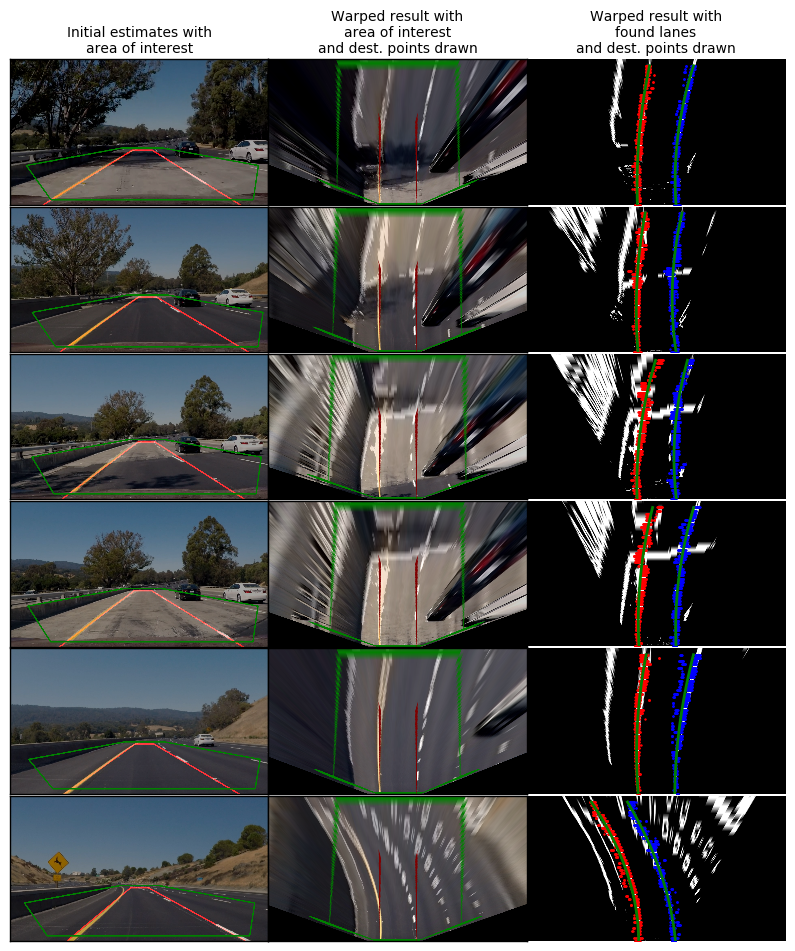

In [1035]:
# Make a list of test images
filepath = "test_images/"
pattern = re.compile("^.+processed.jpg$")
images = glob.glob(filepath+'test*.jpg')

# Setup plot
fig = plt.figure(figsize=(10, len(images)*1.9))
w_ratios = [1 for n in range(3)]
h_ratios = [1 for n in range(len(images))]
grid = gridspec.GridSpec(len(images), 3, wspace=0.0, hspace=0.0, width_ratios=w_ratios, height_ratios=h_ratios)
i = 0

# loop through and display test images and apply current pipeline to them
for idx, fname in enumerate(images):
    # import the image if it is not a saved output
    if not pattern.match(fname):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_size = (img.shape[1], img.shape[0])
        
        # process image
        line_image, masked_edges, lane_info, areaOfInterest = process_image(img)
        ignore_color = np.copy(line_image)*0 # creating a blank color channel for combining

        # generate estimated line image
        line_image = np.dstack((line_image, ignore_color, ignore_color))
        
        # masked overlay estimated lane line
        masked_edges = np.dstack((masked_edges, masked_edges, masked_edges))
        
        # just the image with the estimated lane line projection
        img1 = weighted_img(masked_edges, img)
        img1 = weighted_img(line_image, img1)
        draw_area_of_interest(img1, areaOfInterest, color=[0,128,0], thickness=5)

        # generate overlay line image
        img2 = np.copy(img)
        img2 = weighted_img(masked_edges*2, img)
        draw_area_of_interest_for_projection(img2, areaOfInterest, color=[0,128,0], thickness1=1, thickness2=50)
        draw_parallel_lines_pre_projection(img2, lane_info, color=[128,0,0], thickness=2)
        
        # generate src and dst rects
        us_lane_width = 12     # US highway width: 12 feet wide
        approx_dest = 20       # Approximate distance to vanishing point from end of rectangle
        scale_factor = 15      # scaling for display
        left = -us_lane_width/2*scale_factor
        right = us_lane_width/2*scale_factor
        top = approx_dest * scale_factor
        src = np.float32([lane_info[3],lane_info[4],lane_info[5],lane_info[6]])
        dst = np.float32([[img_size[0]/2+left,top],[img_size[0]/2+right,top],[img_size[0]/2+right,img_size[1]],[img_size[0]/2+left,img_size[1]]])
        img2, M = unwarp_lane(img2, src, dst, mtx)

        img3 = np.copy(masked_edges)
        guide = np.copy(masked_edges)*0
        draw_parallel_lines_pre_projection(guide, lane_info, color=[128,128,0], thickness=50)
        img3, M = unwarp_lane(img3, src, dst, mtx)
        guide, M = unwarp_lane(guide, src, dst, mtx)
        guide = cv2.cvtColor(guide, cv2.COLOR_BGR2GRAY)
        img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
        
        # return left and right column positions
        left, right, distance = find_lane_locations(guide)

        # function to find lane lines points using a sliding window histogram given starting positions
        # return arrays or left, right and y positions
        leftx, rightx, yvals = find_lane_lines_points(img3, left, right, distance)
        
        # Fit a second order polynomial to each lane line
        leftcoefficients = np.polyfit(yvals, leftx, 2)
        leftpolynomial = np.poly1d(leftcoefficients)
        left_fitx = leftpolynomial(yvals)

        rightcoefficients = np.polyfit(yvals, rightx, 2)
        rightpolynomial = np.poly1d(rightcoefficients)
        right_fitx = rightpolynomial(yvals)

        # next image
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img1)
        if i==0:
            ax.set_title('Initial estimates with\narea of interest', size=10)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img2)
        if i==1:
            ax.set_title('Warped result with\narea of interest\nand dest. points drawn', size=10)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        if i==2:
            ax.set_title('Warped result with\nfound lanes\nand dest. points drawn', size=10)
        ax.scatter(leftx, yvals, marker='+', c='r', s=1, zorder=2)
        ax.scatter(rightx, yvals, marker='+', c='b', s=1, zorder=2)
        ax.plot(left_fitx, yvals, color='green', linewidth=2, zorder=3)
        ax.plot(right_fitx, yvals, color='green', linewidth=2, zorder=3)
        ax.set_ylim(719, 0)
        ax.set_xlim(0,1279)
        ax.imshow(img3, cmap='gray',  zorder=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        fig.add_subplot(ax)
        i += 1



## Determine curvature of the lane and vehicle position with respect to center.

Now let's update the pipeline to include calculations to determine curvature of the lane and vehicle position with respect to center.

**I ran the code in the two cells below to update the pipeline to determine curvature of the lane, vehicle position with respect to the center, and apply them to the test images.**

## Warp the detected lane boundaries back onto the original image.

Now let's update the pipeline to warp the processed images back onto the original image.

**I ran the code in the two cells below to update the pipeline to warp the detected lane boundaries back into the original images, and apply them to the test images.**

## Final pipeline test on Images

Now let's build the complete pipeline to work on the images in the directory "test_images" before we try the videos.

**I ran the code in the two cells below to put the entire pipeline together and output the visual display of the lane boundaries and numerical estimation of the lane curvature and vehicle position.**

In [ ]:
# seventh attempt, based on second attempt, second take
#   This version of draw_lines averages out all of the left and right lane lines
#   And just draw a single line for both
#
#   This attempt seems to work for case 1 and 2, most of the Optional Challenge! :)
#   It appears that if we add a yellow_white color filter using inRange and a range of
#   rho larger than 1 with higher thresholds (higher minimum votes) to eliminate extra lines.



def my_image_only_yellow_white_curve1(image):
    # setup inRange to mask off everything except white and yellow
    lower_yellow_white = np.array([192, 192, 32])
    upper_yellow_white = np.array([255, 255, 255])
    mask = cv2.inRange(image, lower_yellow_white, upper_yellow_white)
    return cv2.bitwise_and(image, image, mask=mask)

def my_image_only_yellow_white_curve2(image):
    # setup inRange to mask off everything except white and yellow
    lower_yellow_white = np.array([140, 140, 64])
    upper_yellow_white = np.array([255, 255, 255])
    mask = cv2.inRange(image, lower_yellow_white, upper_yellow_white)
    return cv2.bitwise_and(image, image, mask=mask)

def procimage2(image):
    # mask calculations
    imshape = image.shape
    xbottom1 = int(imshape[1]/16)
    xbottom2 = int(imshape[1]*15/16)
    xtop1 = int(imshape[1]*14/32)
    xtop2 = int(imshape[1]*18/32)
    ybottom1 = imshape[0]
    ybottom2 = imshape[0]
    ytopbox = int(imshape[0]*9/16)

    # Read in the image and convert to grayscale
    gray = grayscale(my_image_only_yellow_white_curve1(image))

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 7 # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and run it
    low_threshold = 5
    high_threshold = 17
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    # We can lift the mask higher now, since the line drawing function is a bit smarter
    vertices = np.array([[(xbottom1,ybottom1),(xtop1, ytopbox), (xtop2, ytopbox), (xbottom2,ybottom2)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 75 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "masked_lines" is a single channel mask
    ignore_color = np.zeros(masked_edges.shape, dtype=np.uint8)
    original_image = np.dstack((masked_edges, ignore_color, ignore_color))

    line_image, lane_info = my_hough_lines2(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # if first attempted failed - that means we are dealing with yellow and white on white.
    #   try second mask
    # if np.array_equal(line_image, original_image):
    if lane_info[0] == -1000:
        # Read in the image and convert to grayscale
        gray = grayscale(my_image_only_yellow_white_curve2(image))

        # Define a kernel size for Gaussian smoothing / blurring
        kernel_size = 13 # Must be an odd number (3, 5, 7...)
        blur_gray = gaussian_blur(gray, kernel_size)

        # Define our parameters for Canny and run it
        low_threshold = 10
        high_threshold = 36
        edges = canny(blur_gray, low_threshold, high_threshold)

        # This time we are defining a four sided polygon to mask
        # We can lift the mask higher now, since the line drawing function is a bit smarter
        masked_edges = region_of_interest(edges, vertices)

        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 16 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 130     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 75 #minimum number of pixels making up a line
        max_line_gap = 100    # maximum gap in pixels between connectable line segments

        # debugging
        # orignial_image = np.dstack((masked_edges, ignore_color, ignore_color))

        # Run Hough on edge detected image
        # Output "masked_lines" is a single channel mask

        line_image, lane_info = my_hough_lines2(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

        # debugging short
        # return weighted_img(line_image, original_image)
    
    #my_draw_masked_area(line_image, vertices)
    #line_image = weighted_img(line_image, original_image)
    # return line_image
   
    # return the merged red colored lines with the image as background
    return weighted_img(line_image, image)


# loop through and display all of the process images
import os
import re
filepath = "test_images/"
pattern = re.compile("^.+processed.jpg$")
files = os.listdir(filepath)
for file in files:
    # import the image if it is not a saved output
    if not pattern.match(file):
        image_filepath = filepath + file
        image = mpimg.imread(image_filepath)
    
        # process image
        image_wlines = procimage2(image)               # attempt 2
        print('Image ', image_filepath, ' has dimensions: ', image.shape)
    
        # next image
        plt.figure()
    
        # plot the image
        plt.imshow(image_wlines)
        
        # writeout the image with "-processed" in the name so it will not be reprocessed.
        plt.savefig(image_filepath.replace(".jpg","-processed.jpg"))


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on three provided videos:

Standard: `project_video.mp4`

Challenge: `challenge_video.mp4`

Harder Challenge: `harder_challenge_video.mp4`

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    # attempt 1
    # result = procimage1(image)
    # attempt 2
    result = procimage2(image)
    # attempt 3
    # result, lane_slope = procimage3(image)
    # attempt 4
    # result, lane_slope = procimage4(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

**Response:**

Hi,

I would have submitted this project earlier if it was just case 1 and 2, but the curve lane with white concrete surface was quite a challenge!  After the second attempt, I was able to do case 1 and 2, but require another five attempts to get to this version, which uses *inRange* to better separate the yellow lane markers from the white concrete surface and at the same time uses a higher *rho* and *threshold* values for the **Hough Transform** line finding algorthm.

Hopefully, the code I submit will work most of the time for all cases.  I have to say that since I am just drawing a single straight line for each left and right side needs improvement.  The line fit seems to work correctly near the bottom of the picture for all cases, but fails dramatically at the horizon where the lane markings are faint.  A better algorthm for fitting curve lane markers would greatly improve this particular version that I am submitting.  I attempted to issolate the middle horizon section by clipping it and processing it separately by resizing it to a higher vertical resolution (version 4), but had to drop this approach since it became too complex and CPU intensive.  I placed all my Jupyter notebooks in an **attempts** subdirectory for you to examine if you are interested.

Although using the *inRange* and higher *rho* and *threshold* values works most of the time, there are still corner cases that causes the lane markings to be incorrectly identified.  Purhaps tuning the *inRange* in another color space would help.  Something to consider is to consider weighing the lines in such a way as to walk back up the lane markings and fill the missing lines as we travers the lines identified by the **Hough Transform** algorthm while ignoring lines not part of the lane markings.  Maybe use the algorthm with 0 minimum gap and fill those gaps ourselves to make a better curve fit?  Another algorthm to consider would be to order the lines output from the **Hough Transform** algorthm in such a way as to separate the lines that are part of the lane from objects on the road, such as other cars, white concrete surfaces, etc.  Use a *Machine Learning* algorthms purhaps?  Something to explore in the future!

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))